# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [127]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from pandas.io.json import json_normalize
import os
import requests, zipfile, io
from geopandas import GeoDataFrame
from fiona.crs import from_epsg
import pylab as pl
import numpy as np
import geopandas as gp
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
%matplotlib inline
import urllib
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster as scp

In [2]:
puidata = os.getenv("PUIDATA")
if not puidata or puidata == '/nfshome/sjs909/PUIdata':
    puidata = '/nfshome/sjs909/PUIDATA'

os.environ["PUIDATA"] = puidata
os.environ["PUIDATA"]

'/nfshome/sjs909/PUIDATA'

In [3]:
# Download the data programatically
# make a list as type string plus years 94, if string is not certain size it will append 0 before it
# then made an empty dataframe
# pull directly from url 
# move directly to PUIDATA
# convert textfile to csv
# close the file

In [3]:
# Download the data programatically
zip_list = (pd.Series(list(range(15)) + list(range(94,100))).astype(str)).str.zfill(2)

In [4]:
csb = pd.DataFrame() # Andrew Hill helped me to formulate the idea to loop the string

for i in range(len(zip_list)):
    url = 'https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp' + zip_list[i] + 'totals.zip?raw=true'
    urllib.request.urlretrieve(url, 'file.gz')
    !mv file.gz $PUIDATA
    zip_ref = zipfile.ZipFile('%s/file.gz' %os.getenv('PUIDATA'))
    zip_ref.extractall(os.getenv('PUIDATA'))
    zip_ref.close()
    data = pd.read_csv(os.getenv('PUIDATA') + '/zipcode_data/zbp' + zip_list[i] + 'totals.txt', dtype='object')
    data['YEAR'] = zip_list[i]
    #print(data.shape)
    csb = pd.concat([csb, data], axis=0)

csb.head()

,AP,EMP,EMPFLAG,EST,NAME,QP1,YEAR,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
0,0,0,A,1,"HOLTSVILLE, NY",0,00,00501,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,259661,8042,NaN,493,"AGAWAM, MA",59833,00,01001,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,169658,6547,NaN,563,"AMHERST, MA",36719,00,01002,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2482,82,NaN,13,"AMHERST, MA",308,00,01003,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5826,717,NaN,48,"AMHERST, MA",2049,00,01004,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
csb.tail()

,AP,EMP,EMPFLAG,EST,NAME,QP1,YEAR,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip
39756,0,0,A,2,"POINT BAKER, AK",0,99,99927,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39757,319,14,NaN,10,"WARD COVE, AK",69,99,99928,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39758,15743,652,NaN,98,"WRANGELL, AK",3429,99,99929,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39759,3661,87,NaN,11,"KETCHIKAN, AK",898,99,99950,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39760,11761161,343205,NaN,10328,UNCLASSIFIED,2894301,99,99999,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# it looks as if when the value is there, it is not there in a different NaN
# if it is fill na()

In [23]:
csb[csb['AP'].isnull()]

,AP,EMP,EMPFLAG,EST,NAME,QP1,YEAR,ZIP,ap,ap_nf,...,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,zip


In [5]:
csb['AP'] = csb['AP'].fillna(csb['ap']) # Total Annual Payroll ($1,000) with Noise
csb['EMP'] = csb['EMP'].fillna(csb['emp']) # Total Mid-March Employees with Noise
csb['EMPFLAG'] = csb['EMPFLAG'].fillna(csb['empflag']) # Data Suppression Flag
csb['EST'] = csb['EST'].fillna(csb['est']).astype(int) # Total Number of Establishments
csb['NAME'] = csb['NAME'].fillna(csb['name']) 
csb['QP1'] = csb['QP1'].fillna(csb['qp1'])  # Total First Quarter Payroll ($1,000) with Noise
csb['ZIP'] = csb['ZIP'].fillna(csb['zip'])

In [24]:
csb.columns

Index(['AP', 'EMP', 'EMPFLAG', 'EST', 'NAME', 'QP1', 'YEAR', 'ZIP', 'ap',
       'ap_nf', 'city', 'cty_name', 'emp', 'emp_nf', 'empflag', 'est', 'name',
       'qp1', 'qp1_nf', 'stabbr', 'zip'],
      dtype='object')

In [6]:
# we want just the year, the zipcode and the number of establishments
csb.drop(labels = ['AP', 'EMP', 'EMPFLAG',  'NAME', 'QP1', 'ap',
       'ap_nf', 'city', 'cty_name', 'emp', 'emp_nf', 'empflag', 'est', 'name',
       'qp1', 'qp1_nf', 'stabbr', 'zip'], axis= 1, inplace = True)

In [7]:
csb.head()

,EST,YEAR,ZIP
0,1,00,00501
1,493,00,01001
2,563,00,01002
3,13,00,01003
4,48,00,01004


In [8]:
# make the year into the column header 
csb = csb.groupby(['ZIP','YEAR'])['EST'].sum().unstack().reset_index() 

In [9]:
csb.head()

YEAR,ZIP,00,01,02,03,04,05,06,07,08,...,11,12,13,14,94,95,96,97,98,99
0,00501,1.0,6.0,11.0,7.0,8.0,2.0,8.0,5.0,3.0,...,2.0,2.0,2.0,4.0,NaN,2.0,4.0,4.0,3.0,2.0
1,01000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,11.0,8.0,NaN,NaN
2,01001,493.0,490.0,490.0,505.0,500.0,509.0,509.0,503.0,477.0,...,436.0,453.0,439.0,458.0,439.0,439.0,433.0,457.0,444.0,469.0
3,01002,563.0,587.0,566.0,586.0,584.0,589.0,582.0,596.0,584.0,...,558.0,572.0,572.0,560.0,450.0,467.0,487.0,500.0,490.0,558.0
4,01003,13.0,13.0,15.0,16.0,15.0,12.0,12.0,16.0,17.0,...,16.0,15.0,15.0,18.0,10.0,10.0,13.0,15.0,14.0,13.0


you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



In [10]:
csb.shape

(42671, 22)

In [13]:
# We want just New York File 

In [ ]:
# Do a spatial join with shapefile to get just the NY zipcodes

In [9]:
#download zipcode shapefile
r = requests.get("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(os.getenv('PUIDATA') + '/zipcode_shape') 

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


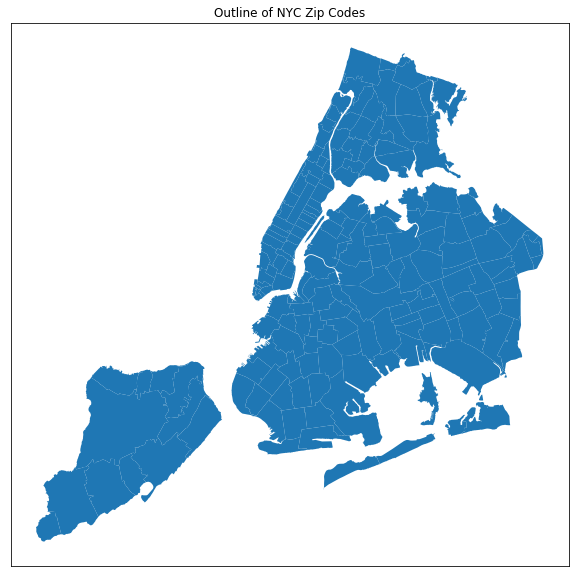

In [16]:
nyczipsshp = gp.read_file(os.getenv("PUIDATA") + "/zipcode_shape/ZIP_CODE_040114.shp")

f, ax = pl.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nyczipsshp.drop_duplicates("ZIPCODE").plot(ax=ax)
pl.title('Outline of NYC Zip Codes')

#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

In [13]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [ ]:
# merge the two togther

In [21]:
csb.head()

YEAR,ZIP,00,01,02,03,04,05,06,07,08,...,11,12,13,14,94,95,96,97,98,99
0,501,1.0,6.0,11.0,7.0,8.0,2.0,8.0,5.0,3.0,...,2.0,2.0,2.0,4.0,NaN,2.0,4.0,4.0,3.0,2.0
1,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,11.0,8.0,NaN,NaN
2,1001,493.0,490.0,490.0,505.0,500.0,509.0,509.0,503.0,477.0,...,436.0,453.0,439.0,458.0,439.0,439.0,433.0,457.0,444.0,469.0
3,1002,563.0,587.0,566.0,586.0,584.0,589.0,582.0,596.0,584.0,...,558.0,572.0,572.0,560.0,450.0,467.0,487.0,500.0,490.0,558.0
4,1003,13.0,13.0,15.0,16.0,15.0,12.0,12.0,16.0,17.0,...,16.0,15.0,15.0,18.0,10.0,10.0,13.0,15.0,14.0,13.0


In [17]:
csbshp = nyczipsshp.merge(csb, left_on ='ZIPCODE', right_on ='ZIP', how='inner')

In [18]:
csbshp.tail()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,11,12,13,14,94,95,96,97,98,99
255,11414,0,Howard Beach,26148.0,6.392882e+07,NY,Queens,36,081,http://www.usps.com/,...,438.0,434.0,444.0,465.0,433.0,445.0,457.0,435.0,430.0,438.0
256,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,...,470.0,495.0,504.0,492.0,487.0,473.0,447.0,434.0,420.0,429.0
257,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,...,114.0,361.0,480.0,590.0,NaN,NaN,NaN,NaN,NaN,NaN
258,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,...,15.0,21.0,18.0,21.0,17.0,18.0,19.0,17.0,22.0,19.0
259,10119,1,New York,0.0,1.263930e+05,NY,New York,36,061,http://www.usps.com/,...,303.0,295.0,293.0,295.0,207.0,212.0,217.0,210.0,235.0,246.0


In [16]:
csbshp.shape

(260, 35)

For about 260 zipcodes we have 20 years of data as well as geography information

In [39]:
csbshp.columns

Index(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry', 'ZIP', '00', '01', '02', '03', '04', '05', '06', '07', '08',
       '09', '10', '11', '12', '13', '14', '94', '95', '96', '97', '98', '99'],
      dtype='object')

In [19]:
# Let's make a separate dataset with just clusters
csbNYC = csbshp.drop(['ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'], axis=1)
#csbNYC = csbNYC.set_index('ZIP')

In [20]:
csbNYC.head()

,ZIP,00,01,02,03,04,05,06,07,08,...,11,12,13,14,94,95,96,97,98,99
0,11436,65.0,57.0,78.0,74.0,84.0,82.0,80.0,84.0,90.0,...,101.0,95.0,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0
1,11213,477.0,493.0,546.0,569.0,570.0,556.0,565.0,556.0,592.0,...,674.0,726.0,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0
2,11212,520.0,527.0,577.0,581.0,586.0,587.0,570.0,587.0,602.0,...,713.0,721.0,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0
3,11225,417.0,422.0,479.0,488.0,492.0,491.0,499.0,514.0,520.0,...,597.0,623.0,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0
4,11218,1161.0,1180.0,1228.0,1247.0,1295.0,1332.0,1331.0,1377.0,1397.0,...,1523.0,1605.0,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0


In [21]:
csbNYC.shape

(260, 22)

In [ ]:
# Now we can standardize

IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

In [23]:
csbNYC.dropna(inplace=True)

In [ ]:
# try to drop rows with nan

In [24]:
scaler = StandardScaler()
scaler.fit(csbNYC.iloc[:,1:])
X_std = scaler.transform(csbNYC.iloc[:,1:])

At 2 clusters, inertia is 1554.2290824446625
At 3 clusters, inertia is 612.6176403907913
At 4 clusters, inertia is 374.0264021850662
At 5 clusters, inertia is 258.99050193414917
At 6 clusters, inertia is 196.6373709327099
At 7 clusters, inertia is 142.39114849126727
At 8 clusters, inertia is 109.20866267213673
At 9 clusters, inertia is 91.71173971300564


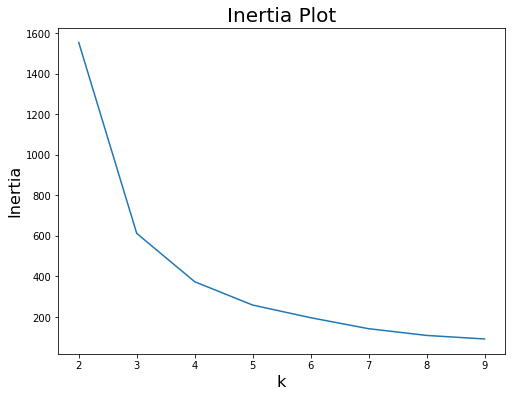

In [25]:
np.random.seed(42)
s = np.zeros(8)
for k in range(0, 8):
    est = KMeans(n_clusters = k+2, n_init = 100)
    est.fit(X_std+1)
    s[k] = est.inertia_
    print('At {0} clusters, inertia is {1}'.format(k+2, s[k]))
    
pl.figure(figsize=(8, 6))
pl.plot(range(2, 10), s,'-')
pl.xlabel('k', fontsize = 16)
pl.ylabel('Inertia', fontsize = 16)
pl.title('Inertia Plot', fontsize = 20)
pl.savefig('Inertia Plot')

This is an inertia plot that shows an empirical evaluation to find the optimal number of clusters, each step measures the relative sum of squared distances to the nearest cluster center
### Find the most optimal number of k's, it looks like the elbow is at 3 
## k = 3

In [26]:
cluster = KMeans(n_clusters = 3, random_state=444, n_init=100)
cluster.fit(X_std)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=100,
    n_jobs=1, precompute_distances='auto', random_state=444, tol=0.0001,
    verbose=0)

In [27]:
csbNYC['clusterLabels'] = cluster.labels_

In [36]:
csbNYC.head()

,ZIP,00,01,02,03,04,05,06,07,08,...,12,13,14,94,95,96,97,98,99,clusterLabels
0,11436,65.0,57.0,78.0,74.0,84.0,82.0,80.0,84.0,90.0,...,95.0,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0,0
1,11213,477.0,493.0,546.0,569.0,570.0,556.0,565.0,556.0,592.0,...,726.0,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0,0
2,11212,520.0,527.0,577.0,581.0,586.0,587.0,570.0,587.0,602.0,...,721.0,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0,0
3,11225,417.0,422.0,479.0,488.0,492.0,491.0,499.0,514.0,520.0,...,623.0,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0,0
4,11218,1161.0,1180.0,1228.0,1247.0,1295.0,1332.0,1331.0,1377.0,1397.0,...,1605.0,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,2


In [ ]:
# merge back with the geodataframe

In [28]:
csbshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,11,12,13,14,94,95,96,97,98,99
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,101.0,95.0,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,674.0,726.0,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,713.0,721.0,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,597.0,623.0,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1523.0,1605.0,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0


In [29]:
csbshp_cluster = csbshp.merge(csbNYC, left_on ='ZIPCODE', right_on ='ZIP', how='inner')

In [39]:
csbshp_cluster.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,12_y,13_y,14_y,94_y,95_y,96_y,97_y,98_y,99_y,clusterLabels
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,95.0,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0,0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,726.0,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0,0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,721.0,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0,0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,623.0,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0,0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1605.0,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,2


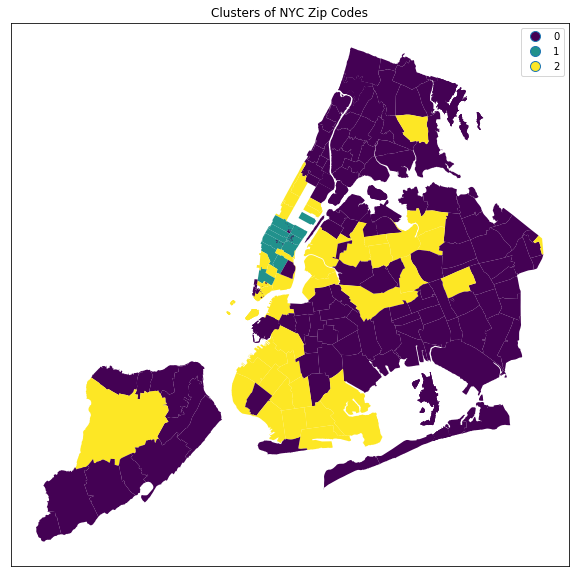

In [96]:
f, ax = pl.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pl.title('Clusters of NYC Zip Codes')
csbshp_cluster.plot(column='clusterLabels',ax=ax, legend=True,categorical=True,cmap='viridis')

Here we see a choropleth of NYC divided by three different clusters of business establishments. It is interesting to see the layout of mid-town Manhattan having its own cluster compared to upper and lower Manhattan. Three clusters seem to be adequate to show the difference in business establishments because we can detect the nuance of Midtown. It is itneresting to see how certain parts of Queens and Brooklyn and inner Staten Island are also classified the same way. 

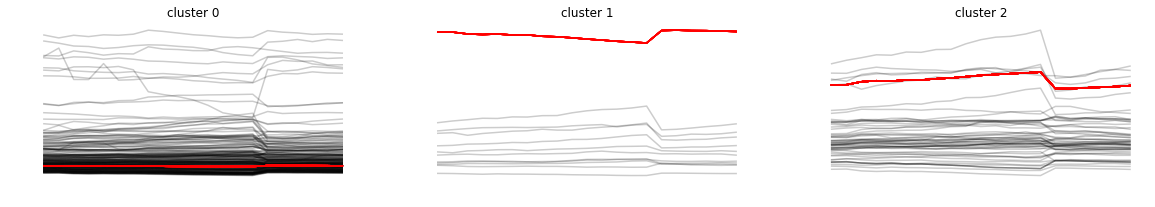

In [105]:
fig = pl.figure(figsize=(20,10))
for i in range(len(csbshp_cluster.clusterLabels.unique())):
    df_plot = (csbshp_cluster[csbshp_cluster['clusterLabels'] == i]).reset_index()
    ax = fig.add_subplot(len(csbshp_cluster.clusterLabels.unique()),len(csbshp_cluster.clusterLabels.unique()),i+1)
    ax.set_title('cluster %s'%i)
    for j in list(df_plot.index):
        ax.plot(range(21), X_std[j], 'k-', alpha=0.2)
        pl.plot(range(21), cluster.cluster_centers_[i], 'r-', label='center of cluster %s'%i)
        ax.set_axis_off()

Here are the distribution of businesses established in black for each zipcode in each cluster as time progresses over the 20 years. We see the center of the cluster labeled in red. It is interesting to see that cluster 1 has its center far away from the levels of business established. Perhaps because the location of these zipcodes are so close to one another...or that perhaps we should have more clusters. 

# Lets try With Agglomerative Clustering

In [ ]:
cluster = KMeans(n_clusters = 3, random_state=444, n_init=100)
cluster.fit(X_std)

In [113]:
agc = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X_std)
labelsag = cluster.labels_
centroidsag = np.zeros((3, X_std.shape[1]))

In [115]:
agc.labels_.shape

(243,)

In [119]:
csbNYC['agcLabels'] = agc.labels_

In [120]:
csbshp_cluster = csbshp.merge(csbNYC, left_on ='ZIPCODE', right_on ='ZIP', how='inner')

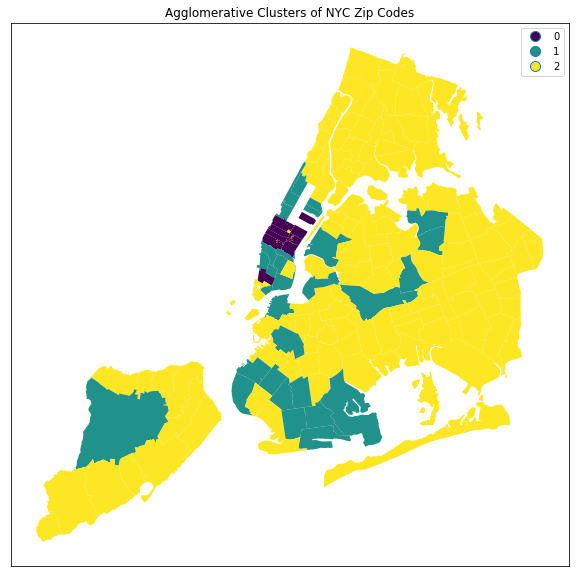

In [126]:
f, ax = pl.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pl.title('Agglomerative Clusters of NYC Zip Codes')
csbshp_cluster.plot(column='agcLabels',ax=ax, legend=True,categorical=True,cmap='viridis')


Here when we use agglomerative clustering, the quantity of cluster 2 grows, eating into the other two clusters. We see midtown shrink where even little pocket inside shows the cluster 2 of low number of business establishements.

In [130]:
csbshp_cluster.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,13_y,14_y,94_y,95_y,96_y,97_y,98_y,99_y,clusterLabels,agcLabels
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,99.0,109.0,51.0,50.0,53.0,51.0,51.0,58.0,0,2
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,755.0,772.0,406.0,420.0,433.0,456.0,476.0,473.0,0,2
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,...,731.0,752.0,505.0,494.0,502.0,527.0,519.0,541.0,0,2
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,...,673.0,696.0,381.0,387.0,388.0,410.0,416.0,409.0,0,2
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,...,1687.0,1736.0,985.0,1015.0,1049.0,1075.0,1118.0,1149.0,2,2


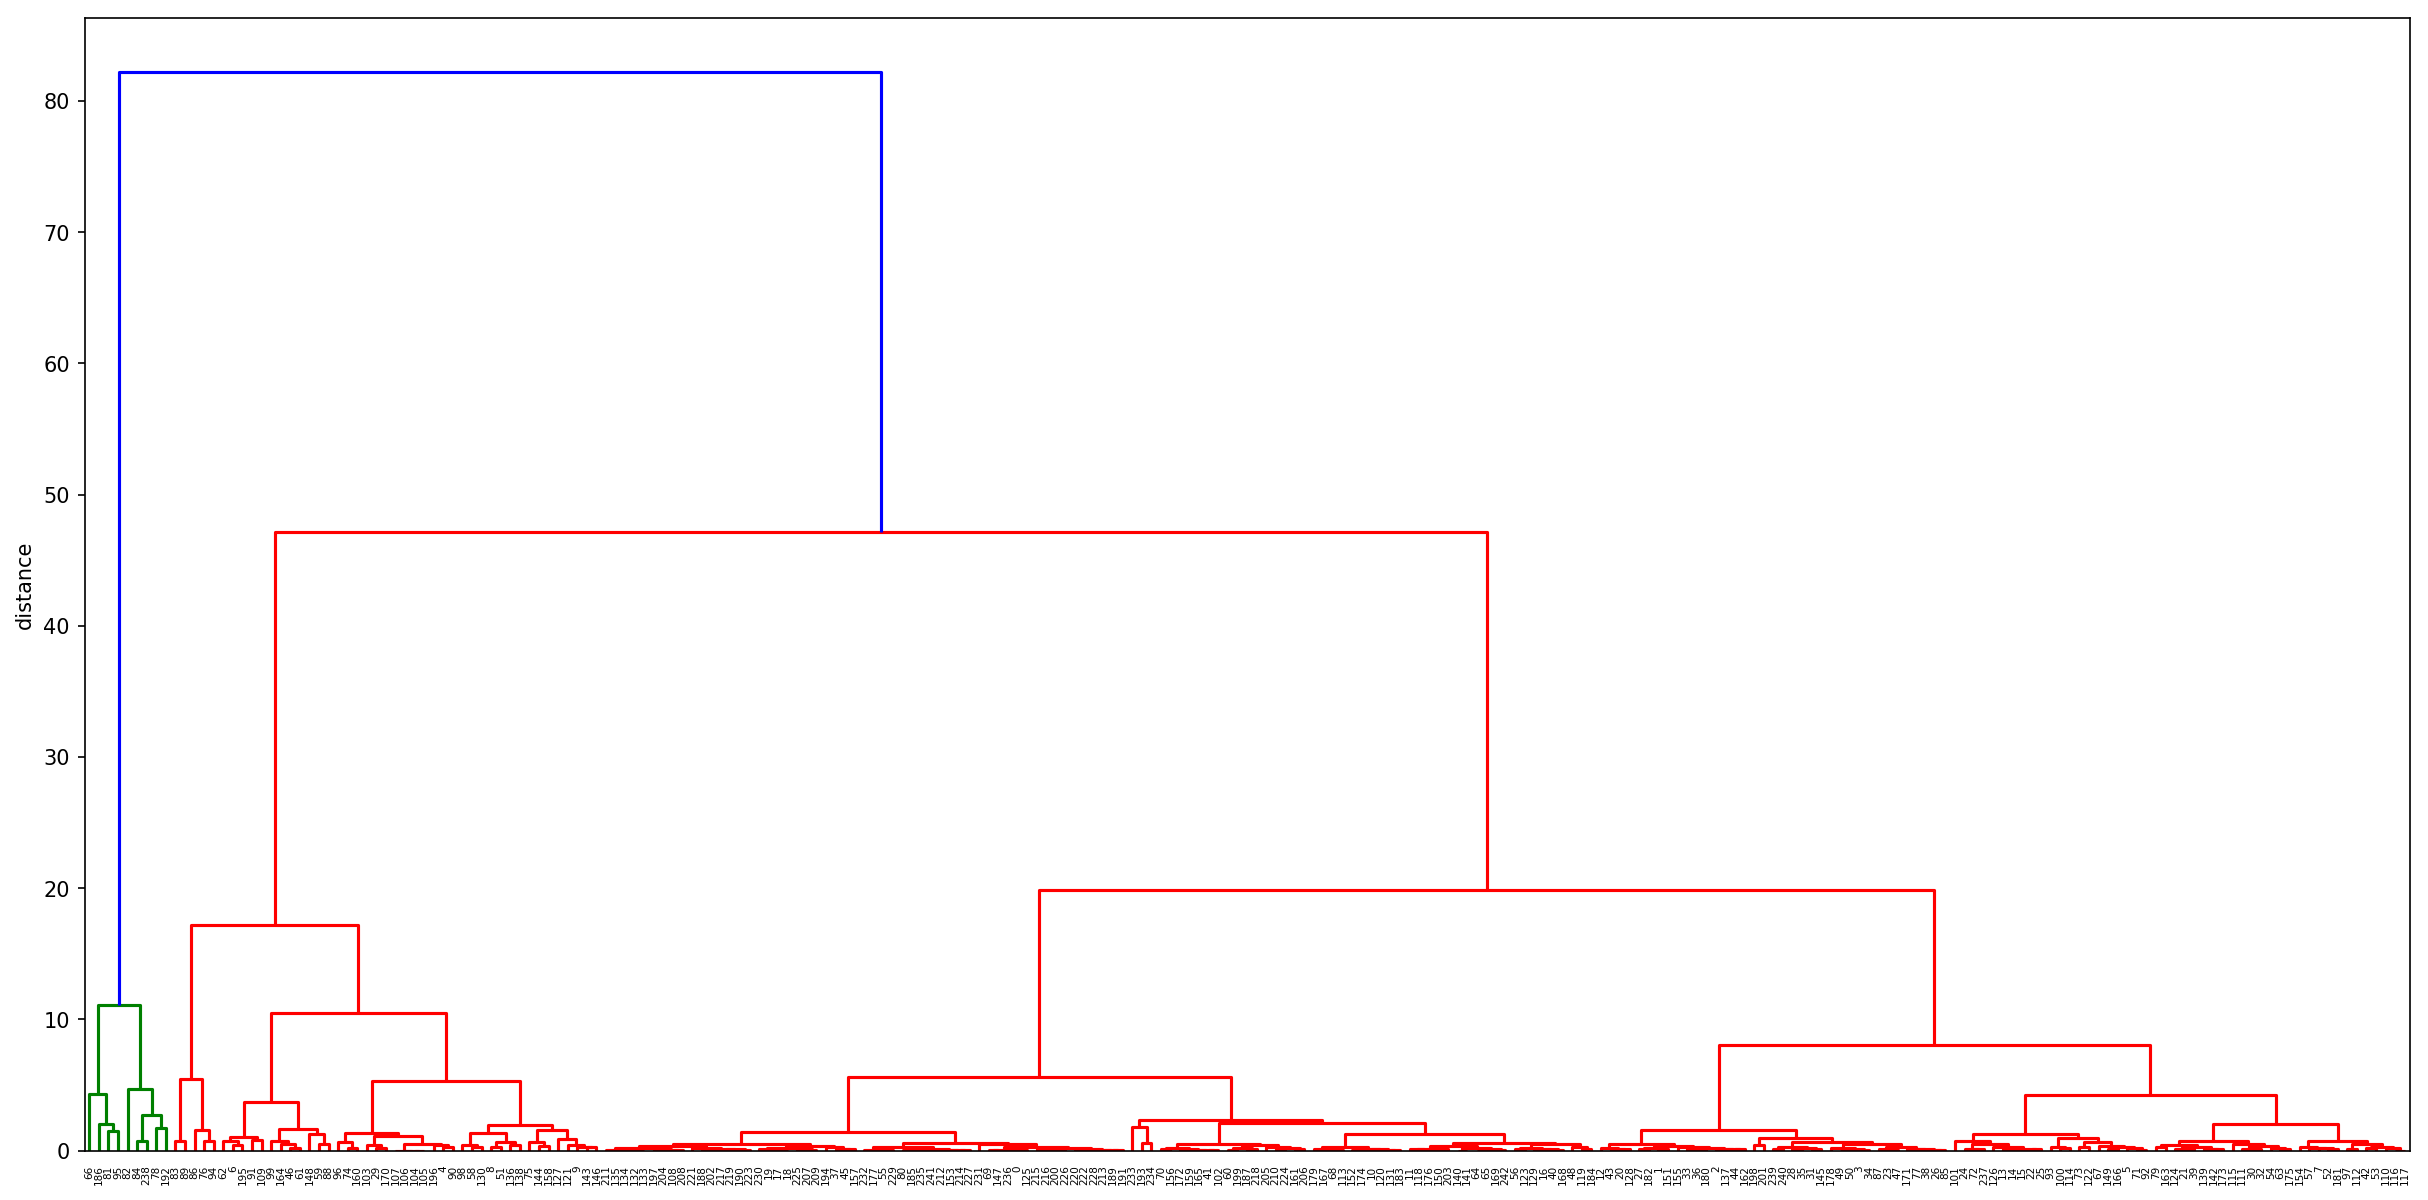

In [140]:
fig = pl.figure(figsize=(20,10), dpi=150)
pl.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(X_std, method='ward'))

We see the branches created by the dendrogram. Come back to this to try and rotate.

# Task 5: Extra Credit
Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:

are there distinct clusters?
do they reflect the card type or station?
To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead:

observation = (observation -observation.mean()) / observation.std() each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

